# Chapter 6: Compare NOAA/NSIDC SIC with Surface Air Temperature
* **Creators:** Ann Windnagel and Robyn Marowitz
* **Affiliation:** [National Snow and Ice Data Center (NSIDC)](https://nsidc.org/home "National Snow and Ice Data Center")
* **History:**
  * 8 January 2025 - Initial version

## Overview

In this notebook, you will investigate how surface air temperature affects sea ice concentration.

This notebook uses surface air temperature anomalies from the NOAA [National Centers for Environmental Prediction (NCEP)](https://www.emc.ncep.noaa.gov/emc.php "NCEP Web Site") Reanalysis products. The data was downloaded from the NOAA [Physcial Sciences Laboratory Monthly/Seasonal Climate Composites](https://psl.noaa.gov/cgi-bin/data/composites/printpage.pl "PSL web application") web application.

<div class="alert alert-block alert-info">
<h3><strong>Note</strong></h3>
The surface air temperature data were pre-processed and reprojected to work with this notebook and the SIC CDR data. The necessary file is in the <code>data_files</code> directory in this repository. The file is called <code>ncep-air-temp-3411crs-oct2020.nc</code>
</div>

### Prerequisites
Read and understand the material in Notebook 1, Notebook 2, and Notebook 3.

### Targeted Level
Advanced

### Learning Outcomes
Once you have completed this notebook, you will be able to:
* Plot surface air temperature data and sea ice concentration data together in one plot.
* Explore the effects of air temperature on sea ice concentration.

### Time Estimate
TBD

### Import relevant packages

In [1]:
from datetime import datetime, date, timedelta
import xarray as xr
import numpy as np
import numpy.ma as ma
import fsspec
import pystac
import matplotlib.pyplot as plt

************************
## Tutorial

Plot sea ice concentration data with surface air temperature
*************************

### Open the October 2020 NCEP Air Temperature Anomaly NetCDF File

Using Xarray, open the NCEP air temperature data for October 2020 and explore the contents of the file.


In [2]:
# Read in the NCEP air temparture anomaly file with xarray
ncep_air_temp_fn = 'data_files/ncep-air-temp-3411crs-oct2020.nc'
ncep_air_temp_nc = xr.open_dataset(ncep_air_temp_fn)
ncep_air_temp_nc

<xarray.Dataset> Size: 551kB
Dimensions:              (x: 304, y: 448)
Coordinates:
  * x                    (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                    (y) float64 4kB -5.338e+06 -5.312e+06 ... 5.838e+06
Data variables:
    polar_stereographic  |S1 1B ...
    Band1                (y, x) float32 545kB ...
Attributes:
    Conventions:                  COARDS
    description:                  Computed from the web page https://psl.noaa...
    GDAL:                         GDAL 3.9.1, released 2024/06/22
    GDAL_NETCDF_DIM_EXTRA:        {time}
    GDAL_NETCDF_DIM_time_DEF:     [1 6]
    GDAL_NETCDF_DIM_time_VALUES:  1935792
    history:                      Fri Aug 30 14:26:39 2024: GDAL CreateCopy( ...
    title:                        Composite Anomaly

### Extract the Air Temperature Anomaly data

From the xarray listing above, you see that the data variable is called `Band1`.

<div class="alert alert-block alert-info">
<strong>Note:</strong> The y-axis for the air temperature data is listed in the reverse order, so you will need to flip the data vertically so that it can be plotted with the SIC CDR data.
</div>

In [3]:
#  Extract Band1 into a numpy array
ncep_air_temp_var = ncep_air_temp_nc.variables['Band1']
ncep_air_temp = np.array(ncep_air_temp_var.data)

# This data set's y-axis is flipped compared to our sea ice data so need to flip it so we can graph them together
ncep_air_temp_flip = np.flipud(ncep_air_temp)

### Plot the Air Temperature Anomaly Data

The surface air temperature anomaly data from NOAA NCEP used in this data set shows how the air temperature for Oct 2020 differs from the 1991 to 2020 climatological average. Areas in the deep red color are where the air temperature is as much as 11 °C above average and areas in the deep blue are where the average is up to 3 °C below average.

<div class="alert alert-block alert-info">
<strong>Note:</strong> The white wedge in the air temperature plot is an artifact of reprojecting the data from WGS84 to polar stereo along the prime meridian.
</div>

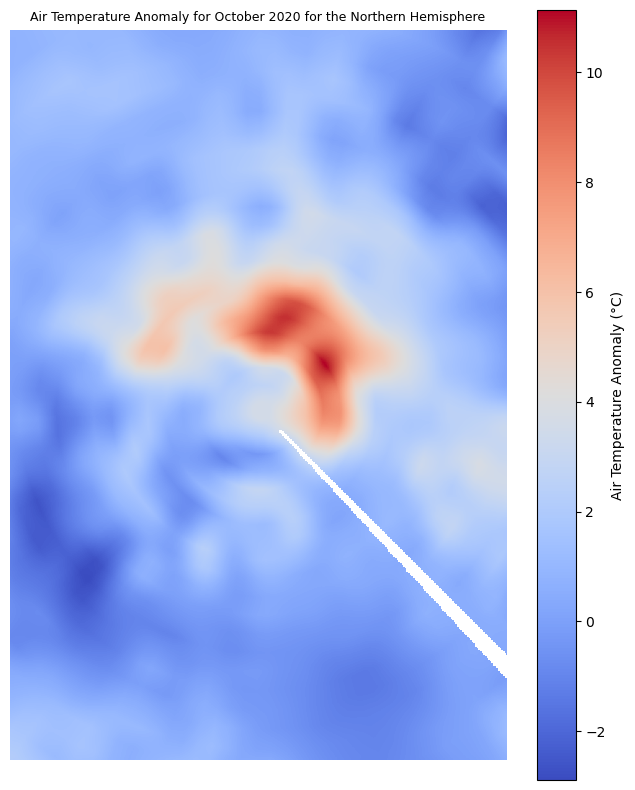

In [4]:
# Set up plot space
fig, ax1 = plt.subplots(figsize=(8, 10))

# Plot air temperature anomaly data
air_temp_plot = ax1.imshow(ncep_air_temp_flip, cmap='coolwarm')
#air_temp_plot = ax1.imshow(ncep_air_temp, cmap='coolwarm')

# Add a colorbar
cbar = fig.colorbar(air_temp_plot, ax=ax1)
# Add a title to the colorbar
cbar.set_label('Air Temperature Anomaly (°C)')

# Plot title and turn off axes
plt.title("Air Temperature Anomaly for October 2020 for the Northern Hemisphere", fontsize=9)
plt.axis('off')
plt.show()

### Open SIC CDR Data

Using STAC and code from Notebook 2, you will open the monthly Northern Hemisphere data. 

<div class="alert alert-block alert-info">
<strong>Note:</strong> In previous notebooks you searched for and opened daily data. In this Tutorial, you will need to read the monthly Northern Hemisphere file, so the <code>item_id</code> you will be looking for will have <code>monthly_nh</code> in it. The sea ice concentration variable in the monthly files has a different name from the daily files. It is called <code>cdr_seaice_conc_monthly</code>.
</div>

In [5]:
# Read in the STAC collection
collection = pystac.Collection.from_file('https://noaadata.apps.nsidc.org/NOAA/G02202_V4/stac/collection.json')

# Extract all the items and their ids from the collection into a variable
items = list(collection.get_all_items())
item_ids = [i.id for i in items]

# Find the id for the monthly NH file
monthly_nh = [i for i in item_ids if "monthly_nh" in i]
monthly_nh_item = collection.get_item(monthly_nh[0], recursive=True)
netcdf_url = monthly_nh_item.assets['netcdf'].href

# Open the data file
fs = fsspec.filesystem('https')
ds = xr.open_dataset(fs.open(netcdf_url))

In [6]:
# Pull out sea ice concentration variable into numpy array. Note that the variable name for the monthly data is cdr_seaice_conc_monthly
cdr_seaice_conc_var = ds.variables['cdr_seaice_conc_monthly']
cdr_seaice_conc = np.array(cdr_seaice_conc_var.data)

# Extract Oct 2020 data. Find index where that occurs.
time_var = ds.variables['time']
time = np.array(time_var.data)
oct_index = np.where(time == np.datetime64(datetime(2020, 10, 1)))

# Pull out the Oct 2020 data from the cdr_seaice_conc variable.
seaice_conc_oct2020 = np.squeeze(cdr_seaice_conc[oct_index[0],:,:])

# Set all concentrations less than 15 to ocean (0)
is_not_seaice = seaice_conc_oct2020 < .15
seaice_conc_oct2020[is_not_seaice] = 0

### Plot Sea Ice

Before you plot the sea ice concentration with the air temperature, take a look at the plot of the October 2020 monthly Northern Hemisphere data on its own.

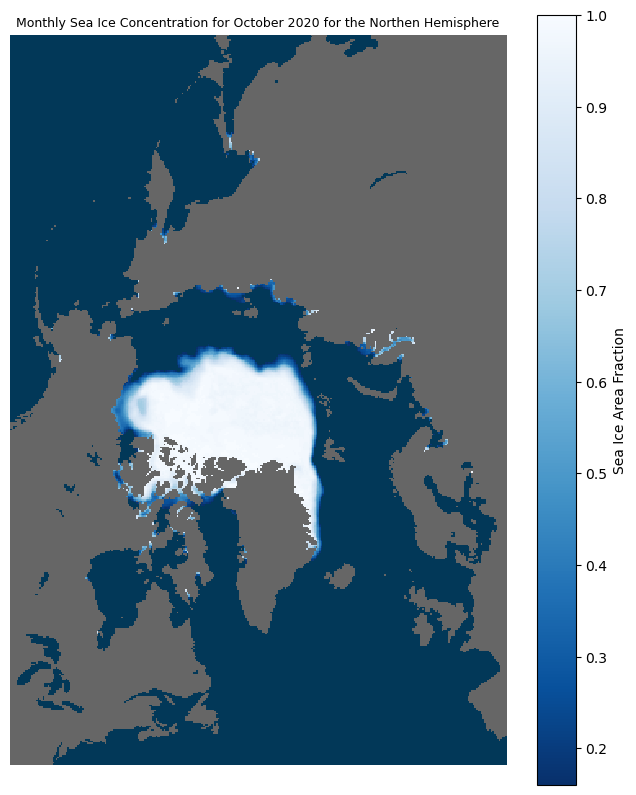

In [7]:
#filter out the ocean where pixels = 0
ocean = ma.masked_outside(seaice_conc_oct2020, 0, 0)

# Only keep sea ice conentration >= 15%
sic_15 = ma.masked_outside(seaice_conc_oct2020, .15, 1)

# filter out the land, coast, and lakes
land = ma.masked_outside(seaice_conc_oct2020, 2.54, 2.54)
coast = ma.masked_outside(seaice_conc_oct2020, 2.53, 2.53)
lakes = ma.masked_outside(seaice_conc_oct2020, 2.52, 2.52)

fig, ax1 = plt.subplots(figsize=(8, 10))
seaice_15_plot = ax1.imshow(sic_15, cmap='Blues_r', interpolation='none')

# Add a colorbar
cbar = fig.colorbar(seaice_15_plot, ax=ax1)
# Add a title to the colorbar
cbar.set_label('Sea Ice Area Fraction')

land_plot = ax1.imshow(land, cmap='Accent_r', interpolation='none')
coast_plot = ax1.imshow(coast, cmap='Accent_r', interpolation='none')
ocean_plot = ax1.imshow(ocean, cmap='PuBu_r', interpolation='none')
lake_plot = ax1.imshow(lakes, cmap='PuBu_r', interpolation='none')

# Plot title and turn off axes
plt.title("Monthly Sea Ice Concentration for October 2020 for the Northen Hemisphere", fontsize=9)
plt.axis('off')
plt.show()

### Plot Sea Ice Concentration and Air Temperature Data Together

When you plot the two datasets together, you can see that areas with above average temperature (red areas off the coast of Russia) do not have any sea ice. These areas show temperatures for October that are 8-11 °C higher than the climatological average (1991-2020). This may seem obvious -- where there are higher temperatures there is less sea ice -- but this is an indication of arctic amplification. 

Arctic amplification is a phenomenon where the surface air temperature of the Arctic is warming faster than the rest of the planet. In October in the Arctic, solar energy is beginning to heavily decline as the Arctic moves into winter. However, even though the solar energy is less, the ice-free ocean is still providing heat, which is leading to the warmer air temperatures. When the Arctic Ocean is covered in sea ice, it reflects the incoming solar rays keeping the ocean and surface air temperatures low. An ice free ocean, on the other hand, absorbs the sun's rays, which makes the ocean warmer. This, in turn, warms the air. This extra heat melts even more sea ice leading to more open ocean and even warmer temperatures. This is known as a climate feedback loop. This is one of the reasons the Artic is warming three times faster than the rest of the globe (Ballinger et al., 2024).

<div class="alert alert-block alert-success">
<h3><strong>Explore</strong></h3>
To learn more about arctic amplification and climate feedback visit NSIDC's <a href="https://nsidc.org/learn/parts-cryosphere/arctic-weather-and-climate/why-arctic-weather-and-climate-matter" title="Arctic Weather and CLimate: Why it matters">Arctic Weather and CLimate: Why it matters</a> web page.
</div>

<div class="alert alert-block alert-info">
<strong>Note:</strong> You will plot the sea ice data with a transparency so you can see the air temperature data underneath.
</div>

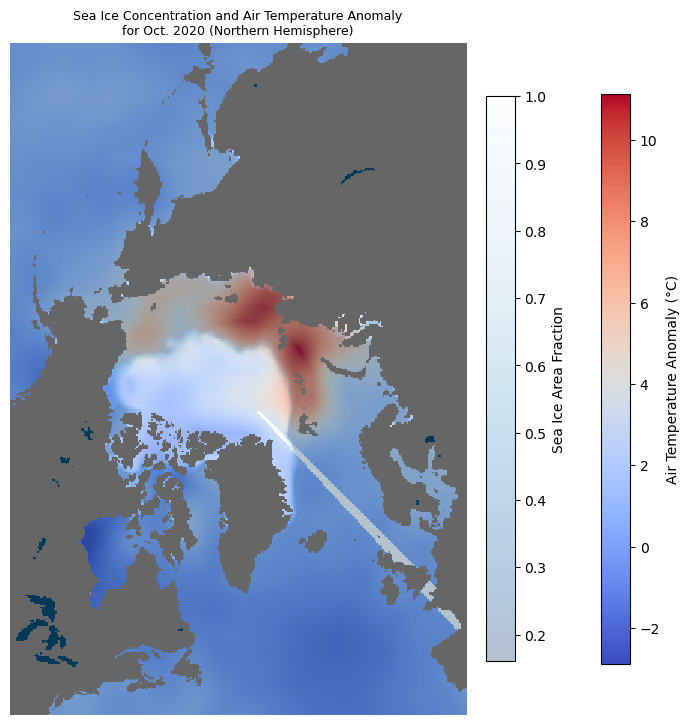

In [8]:
# Set up plot space
fig, ax1 = plt.subplots(figsize=(8, 10))

# Plot air temperature data
air_temp_plot = ax1.imshow(ncep_air_temp_flip, cmap='coolwarm')

# Add a colorbar
cbar1 = fig.colorbar(air_temp_plot, ax=ax1, fraction=0.046, pad=0.14)
# Add a title to the colorbar
cbar1.set_label('Air Temperature Anomaly (°C)')

# Plot sea ice concentration data with a transparency so that the air temperature data shows through
seaice_15_plot = ax1.imshow(sic_15, cmap='Blues_r', interpolation='none', alpha=0.3)

# Add a colorbar
cbar2 = fig.colorbar(seaice_15_plot, ax=ax1, fraction=0.056, pad=0.04)
# Add a title to the colorbar
cbar2.set_label('Sea Ice Area Fraction')

# Plot land surfaces
land_plot = ax1.imshow(land, cmap='Accent_r', interpolation='none')
coast_plot = ax1.imshow(coast, cmap='Accent_r', interpolation='none')
ocean_plot = ax1.imshow(ocean, cmap='PuBu_r', interpolation='none', alpha=0.3)
lake_plot = ax1.imshow(lakes, cmap='PuBu_r', interpolation='none')

# Plot title and turn off axes
plt.title("Sea Ice Concentration and Air Temperature Anomaly\nfor Oct. 2020 (Northern Hemisphere)", fontsize=9)
plt.axis('off')
plt.show()

<div class="alert alert-block alert-success">
<h3><strong>Exercises</strong></h3>
There are no exercises with this notebook.
</div>

### Next Steps

You have completed the six Learning Journey Notebooks that are part of the Sea Ice Concentration CDR Notebook Series from the NOAA Center for Artificial Intelligence (NCAI). NCAI has many other Learning Journey Notebooks. To explore all the tutorials, visit the [NCAI Learning Journey GitHub repository](https://github.com/noaa-ncai/learning-journey "NCAI Learning Journey GitHub Repository")

### Data Statement

Kalnay et al. (1996) The NCEP/NCAR 40-year reanalysis project, Bull. Amer. Meteor. Soc., 77, 437-470.

NCEP-NCAR Reanalysis 1 Surface Air Temperature Anomaly data provided by the NOAA PSL, Boulder, Colorado, USA, from their website at https://psl.noaa.gov.

Huang, B., C. Liu, V. Banzon, E. Freeman, G. Graham, B. Hankins, T. Smith, and H.-M. Zhang, 2020: Improvements of the Daily Optimum Interpolation Sea Surface Temperature (DOISST) Version 2.1, Journal of Climate, 34, 2923-2939. doi: 10.1175/JCLI-D-20-0166.1

Meier, W. N., Fetterer, F., Windnagel, A. K., & Stewart, J. S. (2021). NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration. (G02202, Version 4). [Data Set]. Boulder, Colorado USA. National Snow and Ice Data Center. https://doi.org/10.7265/efmz-2t65.

### References

Ballinger, Thomas J. et al. (2024). NOAA Arctic Report Card 2024 : Surface Air Temperature. https://doi.org/10.25923/mjhx-3j40

### Metadata

* Language/Package(s)
  * Python
  * xarray
  * pystac
  * numpy
  * matplotlib
* Geophysical Keywords
  * Sea Ice Concentration
  * Surface Air Temperature

### Software License

Copyright 2025 NOAA NCAI

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### Content License

[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/ "Createive Commons BY 4.0 License")

### Disclaimer

This Jupyter notebook is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, the United States Department of Commerce, the National Snow and Ice Data Center, or the University of Colorado at Boulder. All NOAA Jupyter notebooks are provided on an 'as is' basis, and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.